! pip install -U --user hmmlearn

# Example

In [1]:
from __future__ import print_function

import datetime
from datetime import timedelta
import numpy as np
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
try:
    from matplotlib.finance import quotes_historical_yahoo_ochl
except ImportError:
    # For Matplotlib prior to 1.5.
    from matplotlib.finance import (
        quotes_historical_yahoo as quotes_historical_yahoo_ochl
    )

from hmmlearn.hmm import GaussianHMM, GMMHMM
import scipy.stats as sp
print(__doc__)

Automatically created module for IPython interactive environment


In [158]:
def HMM(stock, start, end, isPrint = False, isdiff = False):
    quotes = quotes_historical_yahoo_ochl( stock, start, end)

    # Unpack quotes
    dates = np.array([q[0] for q in quotes], dtype=int)
    close_v = np.array([q[2] for q in quotes])
    volume = np.array([q[5] for q in quotes])[1:]
    open_v = np.array([q[1] for q in quotes])
    high_v = np.array([q[3] for q in quotes])
    low_v = np.array([q[4] for q in quotes])
    
    # set observation X
    if isdiff == True:
        diff = np.diff(close_v)
        dates = dates[1:]
        close_v = close_v[1:]
        open_v = open_v[1:]
        high_v = high_v[1:]
        low_v = low_v[1:]
#         X = np.column_stack([diff, close_v, open_v, high_v,low_v]) 
        X = np.column_stack([diff, volume, open_v,high_v])
    else:
        X = np.column_stack([close_v, open_v, high_v, low_v])

    # Make an HMM instance and execute fit
    model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000).fit(X)
    
    # Predict the optimal sequence of internal hidden state
    hidden_states = model.predict(X)
    
    # isPrint == True: plot 
    if isPrint:
        print("Transition matrix")
        print(model.transmat_)
        print()

        print("Means and vars of each hidden state")
        for i in range(model.n_components):
            print("{0}th hidden state".format(i))
            print("mean = ", model.means_[i])
            print("var = ", np.diag(model.covars_[i]))
            print()
            
        fig, ax = plt.subplots(figsize=(15, 5))
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        c = np.array([colours[i,] for i in hidden_states])

        plt.plot(range(len(dates)), close_v, "--" ,color='grey')
        plt.scatter(range(len(dates)), close_v, s=80, color=c)
        ax.set_title("Hidden state")

        # Format the ticks.
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_minor_locator(MonthLocator())
        ax.grid(True)

        plt.show()
    
    # Z_{n+1}
    Zn_post = model.predict_proba(X)[-1]
    Zn1Zn = (model.transmat_.T * Zn_post).T
    Zn1_post = np.sum(Zn1Zn, axis = 0)

    mu = np.sum(model.means_[:,0]*Zn1_post)
    V = np.sum(model.covars_[:,0,0]*Zn1_post**2)
    
    mix_normal = sp.norm(loc = mu, scale = np.sqrt(V))
    
    if isPrint:
        if isdiff == True:
            x = np.linspace(-100,100,1000000)
        else:
            x = np.linspace(0,1000,1000000)
        plt.plot(x, mix_normal.pdf(x))
    
    predict = mix_normal.rvs(size=100)
    
    if isdiff == True:
        return  np.mean(predict) + close_v[-1]
    else:
        return np.mean(predict) 

In [159]:
def MSE(df, df_true):
    output = []
    for i in range(df.shape[1]):
        output.append(sum((df.ix[:,i]- df_true.ix[:,i])**2)/df.shape[1])
    return output

# GOOGLE

In [160]:
# HMM('GOOG', datetime.datetime(2016,1,1), datetime.datetime(2016,4,1),True)

# LinkedIn

In [161]:
# HMM('LNKD', datetime.datetime(2016,3,31)-timedelta(211), datetime.datetime(2016,3,31),True)

# 7 Company

In [162]:
import pandas as pd
from pandas import Series, DataFrame
from datetime import timedelta

In [163]:
company = ["AAPL","FB","LNKD","AMZN","GOOG","MSFT","BABA"]
numdays = 30
base = datetime.datetime(2016,4,30)
preDate = [base - datetime.timedelta(days=x) for x in range(0, numdays)]

In [164]:
# true stock price
df_true = DataFrame(index = preDate, columns = company)
for date in preDate:
    for comp in company:
        true = quotes_historical_yahoo_ochl(comp, date, date)
        if true is None:
            df_true[comp][date] = None
        else:
            df_true[comp][date] = true[0][2]
            

In [165]:
trueDate = np.array([preDate[i] for i,check in enumerate(df_true.ix[:,1]) if not check is None])
df_true = df_true.ix[trueDate,:]

In [166]:
# test
dff = DataFrame(index = trueDate, columns = ['LNKD'])
for date in trueDate:
    dff['LNKD'][date] = HMM('LNKD', date-timedelta(211), date-timedelta(1))

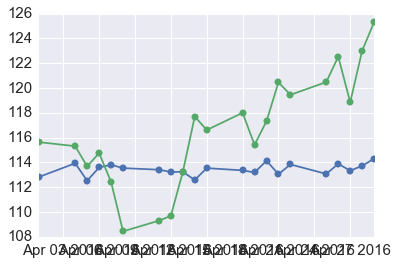

In [167]:
fig, ax = plt.subplots()
ax.plot_date(trueDate, dff['LNKD'][trueDate], marker='o', linestyle='-')
ax.plot_date(trueDate, df_true['LNKD'][trueDate], marker='o', linestyle='-')

In [168]:
df_4m = DataFrame(index = trueDate, columns = company)
df_5m = DataFrame(index = trueDate, columns = company)

for date in trueDate:
    for comp in company:
        df_4m[comp][date] = HMM(comp, date-timedelta(211), date-timedelta(1))
        df_5m[comp][date] = HMM(comp, date-timedelta(211), date-timedelta(1),isdiff = True)

df_4m.to_csv('predict_hmm_4m.csv')
df_5m.to_csv('predict_hmm_5m_2.csv')

Transition matrix
[[  9.60007947e-001   0.00000000e+000   1.64092748e-235   3.99920534e-002]
 [  0.00000000e+000   1.00000000e+000   0.00000000e+000   0.00000000e+000]
 [  1.08960811e-095   1.99036060e-002   9.60192387e-001   1.99040071e-002]
 [  3.25184193e-002   1.42366571e-104   3.25184461e-002   9.34963135e-001]]

Means and vars of each hidden state
0th hidden state
mean =  [ 247.67644917  247.29143666  251.07353533  244.16530975]
var =  [ 20.96405242  20.75922273  17.01294427  19.62469701]

1th hidden state
mean =  [ 112.93342103  113.10105276  115.57921139  110.56815824]
var =  [ 25.70439266  30.00873986  26.6034447   30.83420038]

2th hidden state
mean =  [ 194.18047174  194.36312193  196.93700656  190.48583714]
var =  [ 30.02676921  34.28379334  30.40851447  27.01024497]

3th hidden state
mean =  [ 224.22655116  224.81904775  227.67278908  221.2470764 ]
var =  [ 80.55881484  84.03704102  73.48885696  90.65905591]



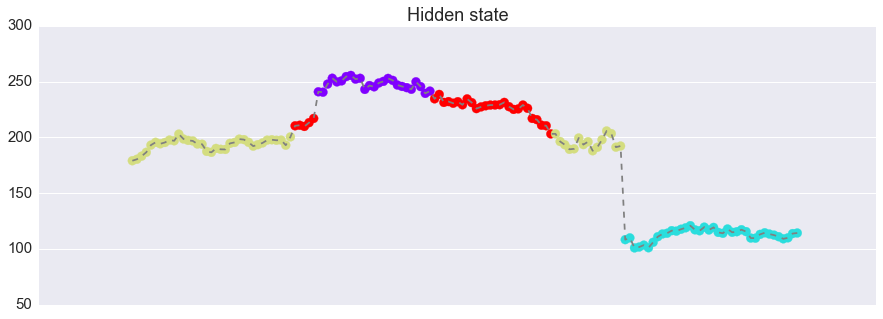

Transition matrix
[[  9.80049640e-001   2.14002504e-153   1.99503598e-002   6.12652544e-082]
 [  0.00000000e+000   0.00000000e+000   1.00000000e+000   4.18541649e-128]
 [  1.40843542e-001   1.38955541e-001   5.81245377e-001   1.38955541e-001]
 [  1.68283510e-060   0.00000000e+000   8.17871254e-015   1.00000000e+000]]

Means and vars of each hidden state
0th hidden state
mean =  [ -4.18050090e-02   1.49486625e+06   2.16142064e+02   2.19050262e+02]
var =  [  1.63253873e+01   3.45483415e+11   5.20427417e+02   5.32739242e+02]

1th hidden state
mean =  [ -8.39000020e+01   4.40814000e+07   1.25339996e+02   1.28990005e+02]
var =  [ 0.01  0.01  0.01  0.01]

2th hidden state
mean =  [  1.52680944e+00   7.77539484e+06   1.66447914e+02   1.70962339e+02]
var =  [  1.10468694e+02   9.89659585e+12   3.02882070e+03   3.00774432e+03]

3th hidden state
mean =  [  3.65524080e-01   3.26277089e+06   1.13423493e+02   1.15635767e+02]
var =  [  6.81585091e+00   1.03288912e+12   2.32005669e+01   2.05606884e+0

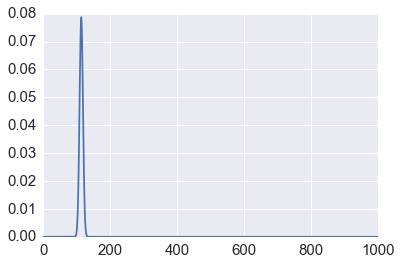

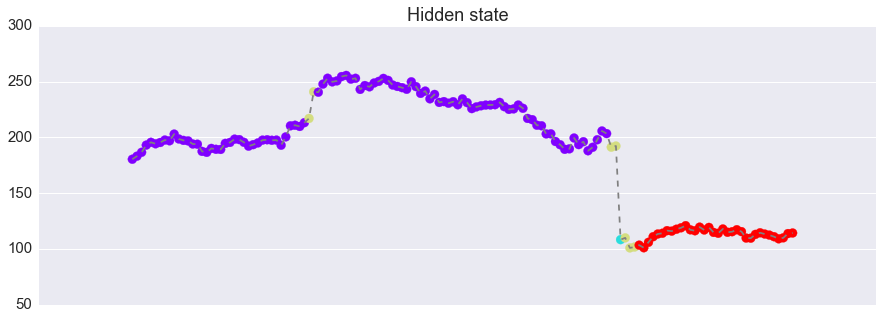

114.57443843473227

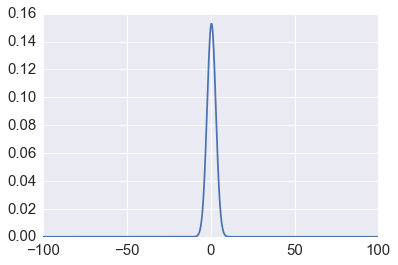

In [169]:
date0 = trueDate[0]
HMM("LNKD", date-timedelta(211), date-timedelta(1),isPrint = True)
HMM("LNKD", date-timedelta(211), date-timedelta(1),isPrint = True,isdiff = True)

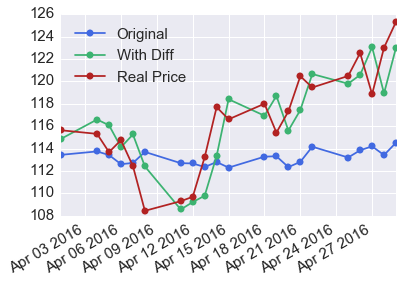

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot_date(trueDate, df_4m['LNKD'][trueDate], marker='o', linestyle='-', label = "Original",color = 'royalblue')
ax.plot_date(trueDate, df_5m['LNKD'][trueDate], marker='o', linestyle='-', label = "With Diff",color = 'mediumseagreen')
ax.plot_date(trueDate, df_true['LNKD'][trueDate], marker='o', linestyle='-', label = "Real Price",color = 'firebrick')

legend = ax.legend(loc='upper left', shadow=True)

fig.autofmt_xdate()
plt.show()

In [156]:
MSE(df_4m, df_true)

[17.911822690375612,
 32.219971711286519,
 81.718450999492077,
 1066.4900080428386,
 475.79474391785419,
 4.5473116522019517,
 7.9938369310870554]

In [157]:
MSE(df_5m, df_true)

[11.177804195600913,
 17.369545334064444,
 36.956026014627064,
 671.67914752813817,
 397.12276986297411,
 3.1904275162153115,
 3.345156872186474]

$P(Z_n | x_1 \dots, x_n) $

In [296]:
Zn_post = model.predict_proba(X)[-1]

$P(Z_{n+1}, Z_{n} | X_1, \dots, X_n) = P(Z_{n+1} | Z_n) * P(Z_n | x_1 \dots, x_n)$

In [297]:
Zn1Zn = (model.transmat_.T * Zn_post).T

$P(Z_{n+1} | X_1, \dots, X_n) = \sum_{i=1}^{4} P(Z_{n+1}, Z_{n} =i | X_1, \dots, X_n) $

In [298]:
Zn1_post = np.sum(Zn1Zn, axis = 0)

In [299]:
Zn1_post 

array([  5.96671768e-05,   3.27469809e-01,   4.40764272e-02,
         6.28394096e-01])

In [30]:
test = quotes_historical_yahoo_ochl(
    "AAPL", datetime.date(2016, 4, 1), datetime.date(2016, 4, 2))

In [31]:
test

[(736055.0, 108.779999, 109.989998, 110.0, 108.199997, 25626200.0)]